# Customer Segmentation using PySpark

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 36 kB/s 
     |████████████████████████████████| 198 kB 53.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=5e0a93053de3a2df139fb48038fafb81ae13c86c75743dcb11cd0d35e9c8a068
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import * # to create a dataframe of a specific type
from pyspark.sql.functions import * # importig SQL functions
from pyspark.sql.window import Window

In [ ]:
spark = SparkSession.builder.getOrCreate()
spark

In [ ]:
type(spark)

pyspark.sql.session.SparkSession

In [ ]:
data = spark.read.csv("OnlineRetail.csv", inferSchema=True, header=True)

In [ ]:
data.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [ ]:
type(data)

pyspark.sql.dataframe.DataFrame

In [ ]:
data.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



In [ ]:
data.toPandas().shape

(75106, 8)

In [ ]:
data.describe().show()

+-------+------------------+------------------+--------------------+-----------------+---------------+-----------------+------------------+--------------+
|summary|         InvoiceNo|         StockCode|         Description|         Quantity|    InvoiceDate|        UnitPrice|        CustomerID|       Country|
+-------+------------------+------------------+--------------------+-----------------+---------------+-----------------+------------------+--------------+
|  count|             75106|             75106|               74903|            75106|          75106|            75106|             46828|         75106|
|   mean| 539467.1225619185|29142.232029228195|                null|8.438047559449311|           null|5.639817591138347|15347.426283420176|          null|
| stddev|1783.9337283632942|19256.674205134572|                null|387.1542882405839|           null|136.3471865808178|1762.9295679137601|          null|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|  

In [ ]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|        203|       0|          0|        0|     28278|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [ ]:
data.groupBy("Country").count().sort("count", ascending=False).show(10)

+--------------+-----+
|       Country|count|
+--------------+-----+
|United Kingdom|69754|
|       Germany| 1270|
|        France| 1049|
|          EIRE|  592|
|         Spain|  460|
|   Netherlands|  292|
|      Portugal|  242|
|   Switzerland|  175|
|       Belgium|  158|
|         Italy|  155|
+--------------+-----+
only showing top 10 rows



In [ ]:
# Customer distribution by country

rtl_data = data["Country", "CustomerID"].distinct().groupBy("Country").agg(count
          ("CustomerID").alias("Count")).withColumn('Total', sum('Count').over
          (Window.partitionBy())).withColumn('%', (col('Count')/col('Total'))*100).sort("Count", ascending=False)
rtl_data.show(5)

+--------------+-----+-----+------------------+
|       Country|Count|Total|                 %|
+--------------+-----+-----+------------------+
|United Kingdom| 1206| 1341| 89.93288590604027|
|       Germany|   38| 1341|2.8337061894108873|
|        France|   32| 1341|  2.38627889634601|
|         Spain|    9| 1341|0.6711409395973155|
|     Australia|    8| 1341|0.5965697240865026|
+--------------+-----+-----+------------------+
only showing top 5 rows



In [ ]:
# customers from UK
rtl_data = data.filter(col("Country") == "United Kingdom")

rtl_data = rtl_data.filter(col("CustomerID").isNotNull())

print(rtl_data.toPandas().shape)
rtl_data.show(5)
rtl_data.describe().show()

(41591, 8)
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows

+-------+-----------------+----------

In [ ]:
rtl_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in rtl_data.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|          0|       0|          0|        0|         0|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [ ]:
rtl_data.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [ ]:
rtl_data.describe().show()

+-------+-----------------+------------------+--------------------+------------------+---------------+------------------+------------------+--------------+
|summary|        InvoiceNo|         StockCode|         Description|          Quantity|    InvoiceDate|         UnitPrice|        CustomerID|       Country|
+-------+-----------------+------------------+--------------------+------------------+---------------+------------------+------------------+--------------+
|  count|            41591|             41591|               41591|             41591|          41591|             41591|             41591|         41591|
|   mean|539312.0010625942|29169.132591201716|                null|10.552403164146089|           null|3.1664247072680225|15632.166069582361|          null|
| stddev|1828.039495980516| 19154.23269002299|                null| 518.6643369141226|           null| 5.880899040638542|1622.9426762566093|          null|
|    min|           536365|             10002| 4 PURPLE FLOCK D.

In [ ]:
# To remove negative Quantities
rtl_data = rtl_data.filter(col("Quantity") > 0)
# Total Amount column
rtl_data = rtl_data.withColumn("TotalAmount", round(col("Quantity") * col("UnitPrice")))

In [ ]:
rtl_data.limit(5).toPandas()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,15.0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,22.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.0


### Filtering Data

In [ ]:
rtl_data[rtl_data.Description.isin('WHITE HANGING HEART T-LIGHT HOLDER')].limit(5).show()

+---------+---------+--------------------+--------+---------------+---------+----------+--------------+-----------+
|InvoiceNo|StockCode|         Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|TotalAmount|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+-----------+
|   536365|   85123A|WHITE HANGING HEA...|       6| 12/1/2010 8:26|     2.55|     17850|United Kingdom|       15.0|
|   536373|   85123A|WHITE HANGING HEA...|       6| 12/1/2010 9:02|     2.55|     17850|United Kingdom|       15.0|
|   536375|   85123A|WHITE HANGING HEA...|       6| 12/1/2010 9:32|     2.55|     17850|United Kingdom|       15.0|
|   536390|   85123A|WHITE HANGING HEA...|      64|12/1/2010 10:19|     2.55|     17511|United Kingdom|      163.0|
|   536394|   85123A|WHITE HANGING HEA...|      32|12/1/2010 10:39|     2.55|     13408|United Kingdom|       82.0|
+---------+---------+--------------------+--------+---------------+-----

In [ ]:
rtl_data[rtl_data.Description.like('%WHITE%')].show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-----------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|TotalAmount|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-----------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|       15.0|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|       20.0|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|       20.0|
|   536373|   85123A|WHITE HANGING HEA...|       6|12/1/2010 9:02|     2.55|     17850|United Kingdom|       15.0|
|   536373|    71053| WHITE METAL LANTERN|       6|12/1/2010 9:02|     3.39|     17850|United Kingdom|       20.0|
+---------+---------+--------------------+--------+--------------+---------+----

In [ ]:
rtl_data.filter(rtl_data.Quantity > 50000).show()

+---------+---------+--------------------+--------+---------------+---------+----------+--------------+-----------+
|InvoiceNo|StockCode|         Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|TotalAmount|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+-----------+
|   541431|    23166|MEDIUM CERAMIC TO...|   74215|1/18/2011 10:01|     1.04|     12346|United Kingdom|    77184.0|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+-----------+



In [ ]:
df = rtl_data.toPandas()

In [ ]:
print(df.InvoiceDate.min())
print(df.InvoiceDate.max())

1/10/2011 10:32
12/9/2010 9:49


In [ ]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [ ]:
# calculating the monetary values
monetary =df.groupby("CustomerID").TotalAmount.sum()
monetary = monetary.reset_index() 
monetary.head()

,CustomerID,TotalAmount
0,12346,77184.0
1,12747,1012.0
2,12748,4690.0
3,12820,172.0
4,12826,710.0


In [ ]:
# calculating the frequency values
frequency=df.groupby("CustomerID").InvoiceNo.count()
frequency = frequency.reset_index()
frequency.head()

,CustomerID,InvoiceNo
0,12346,1
1,12747,20
2,12748,693
3,12820,11
4,12826,49


In [ ]:
#calculating our recency value
LastDate=df.InvoiceDate.max() #calculating the last date of InvoiceDate
LastDate = LastDate + pd.DateOffset(days=1)
df["Diff"] = LastDate - df.InvoiceDate
recency = df.groupby("CustomerID").Diff.min()
recency = recency.reset_index()
recency.head()

,CustomerID,Diff
0,12346,11 days 03:53:00
1,12747,8 days 23:53:00
2,12748,11 days 03:39:00
3,12820,12 days 01:20:00
4,12826,2 days 01:48:00


In [ ]:
rmf = monetary.merge(frequency, on = "CustomerID")
rmf = rmf.merge(recency, on = "CustomerID")
rmf.columns = ["CustomerID", "Monetary", "Frequence", "Recency"]
RMF1 = rmf.drop("CustomerID",axis =1) #dropping customer id and storing it into RMF1
RMF1.Recency = RMF1.Recency.dt.days
RMF1.head()

,Monetary,Frequence,Recency
0,77184.0,1,11
1,1012.0,20,8
2,4690.0,693,11
3,172.0,11,12
4,710.0,49,2


In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
rfm_numbers = spark.read.csv("customer_rfm_numbers.csv", inferSchema=True, header=True)

In [ ]:
rfm_numbers.show(5)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     15619|     11|        1|   337.0|
|     17389|      1|       34| 31852.0|
|     14450|    181|        3|   485.0|
|     15727|     17|        7|  5220.0|
|     15790|     11|        1|   225.0|
+----------+-------+---------+--------+
only showing top 5 rows



In [ ]:
rfm_numbers_df = rfm_numbers.toPandas()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

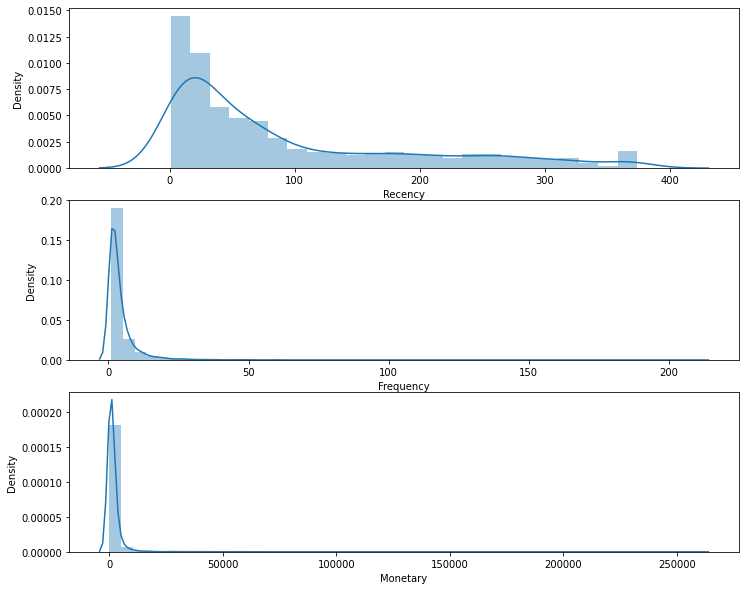

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,10))
# Plot distribution of recency
plt.subplot(3, 1, 1)
sns.distplot(rfm_numbers_df['Recency'])
# Plot distribution of frequency
plt.subplot(3, 1, 2)
sns.distplot(rfm_numbers_df['Frequency'])
# Plot distribution of monetary
plt.subplot(3, 1, 3)
sns.distplot(rfm_numbers_df['Monetary'])

In [ ]:
# remove zero and negative numbers
rfm_data = (rfm_numbers.withColumn("Monetary", when(col("Monetary") <= 0, 1).otherwise(col("Monetary"))))

In [ ]:
features = rfm_data.columns[1:]

In [ ]:
rfm_data.show(5)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     15619|     11|        1|   337.0|
|     17389|      1|       34| 31852.0|
|     14450|    181|        3|   485.0|
|     15727|     17|        7|  5220.0|
|     15790|     11|        1|   225.0|
+----------+-------+---------+--------+
only showing top 5 rows



In [ ]:
# vectorize all features
assembler = VectorAssembler(inputCols=features, outputCol="rfm_features")
assembled_data = assembler.transform(rfm_data)
assembled_data = assembled_data.select('CustomerID', 'rfm_features')
assembled_data.show(5)

+----------+------------------+
|CustomerID|      rfm_features|
+----------+------------------+
|     15619|  [11.0,1.0,337.0]|
|     17389|[1.0,34.0,31852.0]|
|     14450| [181.0,3.0,485.0]|
|     15727| [17.0,7.0,5220.0]|
|     15790|  [11.0,1.0,225.0]|
+----------+------------------+
only showing top 5 rows



In [ ]:
# Standardization 
scaler = StandardScaler(inputCol='rfm_features', outputCol='rfm_standardized')
data_scale = scaler.fit(assembled_data)
scaled_data = data_scale.transform(assembled_data)
scaled_data.show(5)

+----------+------------------+--------------------+
|CustomerID|      rfm_features|    rfm_standardized|
+----------+------------------+--------------------+
|     15619|  [11.0,1.0,337.0]|[0.11052107132513...|
|     17389|[1.0,34.0,31852.0]|[0.01004737012046...|
|     14450| [181.0,3.0,485.0]|[1.81857399180447...|
|     15727| [17.0,7.0,5220.0]|[0.17080529204793...|
|     15790|  [11.0,1.0,225.0]|[0.11052107132513...|
+----------+------------------+--------------------+
only showing top 5 rows



### Using the Elbow Method to find the optimal number of clusters

In [ ]:
costs = np.zeros(10)
# Apply k-means with different value of k
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('rfm_standardized')
    model = kmeans.fit(scaled_data)
    costs[k] = model.summary.trainingCost

Text(0.5, 1.0, 'Elbow Curve')

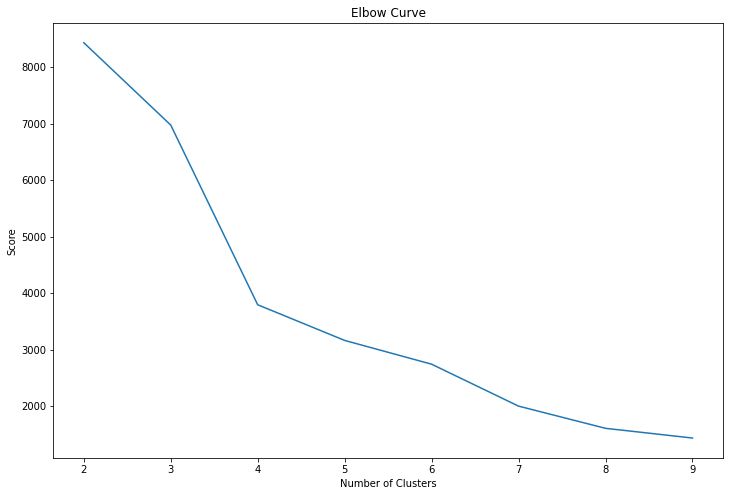

In [ ]:
# Plot the cost
df_cost = pd.DataFrame(costs[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

fig, ax = plt.subplots(1, 1, figsize =(12, 8))
ax.plot(df_cost.cluster, df_cost.cost)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Score')
ax.set_title('Elbow Curve')

In [ ]:
df_cost

,cluster,cost
0,2,8432.530690
1,3,6975.131003
2,4,3794.383657
3,5,3162.975505
4,6,2742.220294
5,7,2000.024796
6,8,1607.200844
7,9,1435.362996


### K Means Clustering

In [ ]:
k_means = KMeans(featuresCol='rfm_standardized', k=4)
model = k_means.fit(scaled_data)
predictions = model.transform(scaled_data)

result = predictions.select('CustomerID', 'prediction')

In [ ]:
result.show(5)

+----------+----------+
|CustomerID|prediction|
+----------+----------+
|     15619|         0|
|     17389|         1|
|     14450|         3|
|     15727|         0|
|     15790|         0|
+----------+----------+
only showing top 5 rows



In [ ]:
rfm_score = spark.read.csv('retail_loyalty_rfm.csv', inferSchema=True, header=True)
rfm_score = rfm_score.select("CustomerID", "Recency", "Frequency", "Monetary", "Loyalty")
rfm_score.show(5)

+----------+-------+---------+--------+--------+
|CustomerID|Recency|Frequency|Monetary| Loyalty|
+----------+-------+---------+--------+--------+
|     16678|      3|      163|  3111.0|Platinum|
|     17735|      3|      690| 13207.0|Platinum|
|     17139|     16|      478| 10750.0|Platinum|
|     13408|      2|      478| 28127.0|Platinum|
|     17389|      1|      213| 31852.0|Platinum|
+----------+-------+---------+--------+--------+
only showing top 5 rows



In [ ]:
combined_result = result.join(rfm_score, on='CustomerID', how='inner')

In [ ]:
result = combined_result.toPandas()

In [ ]:
import seaborn as sns

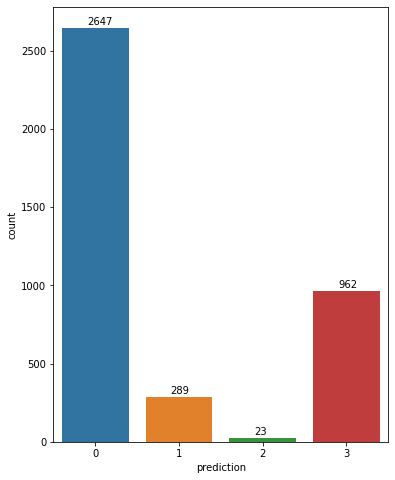

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sns.countplot(x="prediction", data=result)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 20))

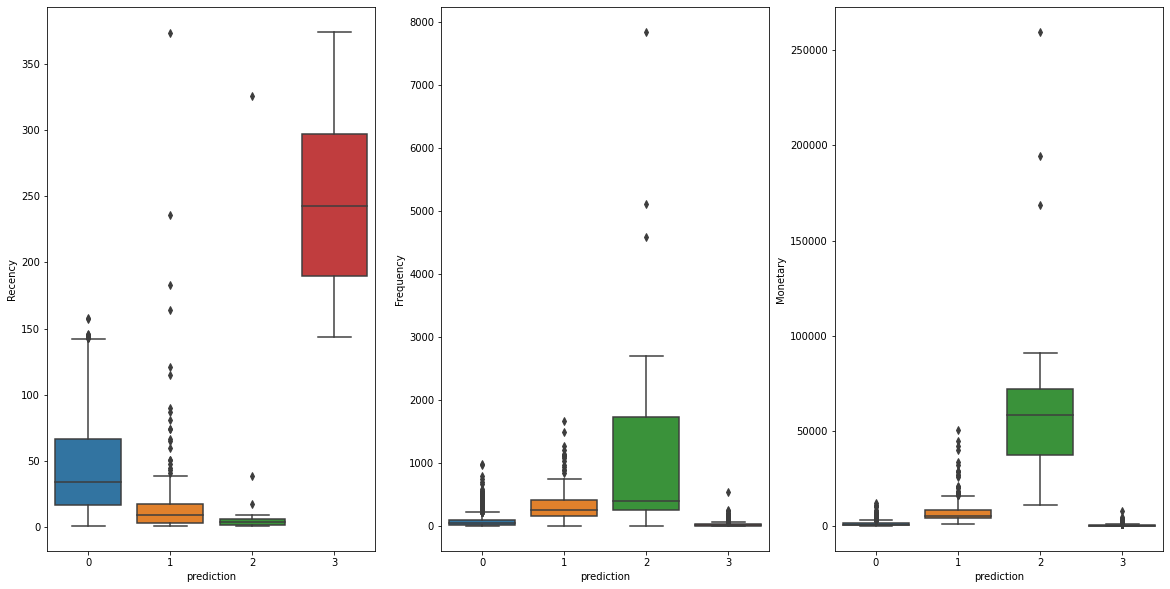

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
sns.boxplot(x='prediction', y='Recency', data=result, ax=ax[0])
sns.boxplot(x='prediction', y='Frequency', data=result, ax=ax[1])
sns.boxplot(x='prediction', y='Monetary', data=result, ax=ax[2])

### Observation

*   Cluster-2 has high frequency and monetary, whereas Cluster 3 has high recency but low frequency and recency.
* High recency means they have not purchased anything from a long time.

